# Chemical Similarity

## Aim of this lab

To use different similarity metrics and fingerprints to calculate chemical similarity. 

### Objectives

* Calculate chemical similarity
* Retrieve the most similar compounds from a chemical dataset. 


## Background

Chemical similarity is a widely used concept in chemistry, drug discovery, and especially cheminformatics.  The chemical similiarity principal states that two molecules that have a similiar structure have similar physicochemical and biological properties.  We know this to be true when we look at the common backbounds or scaffolds that are necessary for binding to a certain receptor or drug target.  Therefore finding similar compounds to a particular chemical of interest is often a widely needed activity in chemistry.  For example, if you had a compound that was a drug and wanted to develop new drugs for that same indication, finding chemicals that look similar to it would be a good place to start. 

But what is similarity? How we define similarity is not necessarily a trivial excercise and is often context dependent.  In fact, the nature of similarity is wholy dependent on how we choose to view or represent certain objects.  Typically when we define chemical similarity it involves two important processes, the similarity function (i.e., the calculation to derive similarity) and the descriptors (i.e., the numerical representation of chemicals such as fingerprints or descriptors).  Often times the metric depends on the descriptors as some are only valid for integers like fingerprints.   

### Descriptors

Here we will calculate the chemical descriptors of our example dataset for RDKit descriptors, ECFP6, and MACC Keys

In [1]:
from rdkit import Chem 
from rdkit.Chem import PandasTools
import pandas as pd

,Name,MolSmiles,Bio_Activity,ID,ROMol
0,Mol_0,CC(C)(C)OC(=O)c1c2n(cn1)-c3ccccc3C(=O)N(C2)C,-1.28,,
1,Mol_1,CN1Cc2c(ncn2-c3ccc(cc3C1=O)Cl)C(=O)OC,-0.62,,
2,Mol_2,CCCOC(=O)c1c2n(cn1)-c3ccc(cc3C(=O)N(C2)C)Cl,-0.13,,

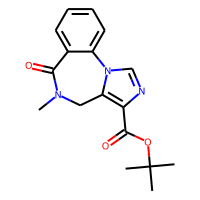
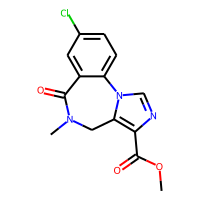
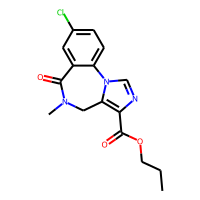

In [2]:
df = PandasTools.LoadSDF('data/DIAZEPAM_w_name.sdf')
df.head(3)

To create descriptors, we'll use the same functions that we used in the Lab on Molecular Descriptors. 

In [3]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

def calc_descriptors_from_mol(mol):
    """
    Encode a molecule from a RDKit Mol into a set of descriptors.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    Returns
    -------
    list
        The set of chemical descriptors as a list.

    """
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])
    return list(calc.CalcDescriptors(mol))

def calc_fp_from_mol(mol, method="maccs", n_bits=2048):
    """
    Encode a molecule from a RDKit Mol into a fingerprint.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    if method == "maccs":
        return list(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan4":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan6":
        return list(AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return list(MACCSkeys.GenMACCSKeys(mol))

In [4]:
desc_list = []
maccs_list = []
ecfp_list = []

for mol in df.ROMol.tolist():
    desc = calc_descriptors_from_mol(mol)
    maccs = calc_fp_from_mol(mol, method="maccs")
    ecfp = calc_fp_from_mol(mol, method="morgan6", n_bits=1024)
    desc_list.append(desc)
    maccs_list.append(maccs)
    ecfp_list.append(ecfp)
    
desc_frame = pd.DataFrame(desc_list)
maccs_frame = pd.DataFrame(maccs_list)
ecfp_frame = pd.DataFrame(ecfp_list)

### Metrics

#### Tanimoto/Jaccard Similarity

In this descriptor frames, we can see that the rows represent an indivual molecules and the columns (0 -> 166) are the fragments, each specifying a unique substructure with a 1 denoting the presence and 0 denoting the absence of a fragment.  The entirity of this would be known as a 'fingerprint'.  

Using these fingerprints, we can calculate the similarity between molecules based on the number of shared features.  The most common measure for this is the Tanimoto coeffiecient, also known as the [Jaccard  index](https://en.wikipedia.org/wiki/Jaccard_index).  Mathematicall it is defined as:

$$J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

Where $A$ and $B$ are fingerprints.  Let's calculate the similarity between every molecule in the dataset using.  We can write code for this ourselves, but its always easier (and sometimes faster) to use code already written.  The machine learning library scikit-learn has many useful functions.  Here we can calculate the jaccard distance, with the Jaccard index just being 1-distance.

In [5]:
from sklearn.metrics.pairwise import pairwise_distances

jac_sim = pd.DataFrame(1 - pairwise_distances(maccs_frame.values, metric="jaccard"))

jac_sim.head()

/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,0.847458,0.757576,0.898305,0.753846,0.932203,0.825397,0.870968,0.770492,0.734375,...,0.809524,0.833333,0.632353,0.793651,0.676923,0.651515,0.931034,0.565217,0.567164,0.441176
1,0.847458,1.000000,0.885246,0.947368,0.883333,0.915254,0.900000,0.885246,0.783333,0.864407,...,0.793651,0.703125,0.746032,0.750000,0.770492,0.770492,0.790323,0.671875,0.677419,0.539683
2,0.757576,0.885246,1.000000,0.843750,0.904762,0.818182,0.890625,0.876923,0.809524,0.887097,...,0.764706,0.731343,0.800000,0.724638,0.769231,0.825397,0.710145,0.701493,0.707692,0.485714
3,0.898305,0.947368,0.843750,1.000000,0.841270,0.966102,0.918033,0.903226,0.746032,0.822581,...,0.841270,0.750000,0.712121,0.796875,0.761905,0.734375,0.838710,0.641791,0.646154,0.515152
4,0.753846,0.883333,0.904762,0.841270,1.000000,0.815385,0.830769,0.875000,0.806452,0.885246,...,0.761194,0.701493,0.854839,0.695652,0.765625,0.883333,0.705882,0.671642,0.703125,0.500000


In [6]:
%matplotlib inline

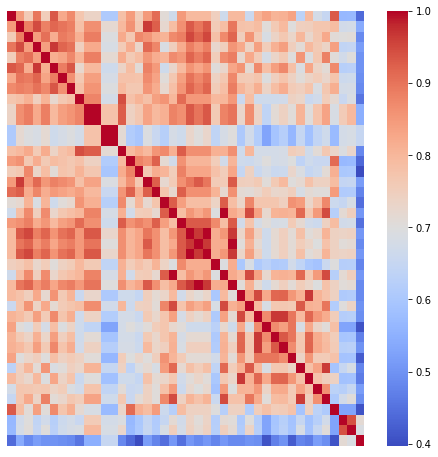

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(jac_sim, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.show()

#### Dice Coeffecient

$$DCE(A,B) = \frac{2{|A \cap B|}}{|A| + |B|}$$

There is no dice coefficient in sklearn, but the scipy library (which is heavily used by sklearn) has this calculative available.

In [8]:
from scipy.spatial.distance import pdist, squareform
dice_sim = pd.DataFrame(1 - squareform(pdist(maccs_frame.values, 'dice')))

dice_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,0.917431,0.862069,0.946429,0.859649,0.964912,0.904348,0.931034,0.870370,0.846847,...,0.894737,0.909091,0.774775,0.884956,0.807339,0.788991,0.964286,0.722222,0.723810,0.612245
1,0.917431,1.000000,0.939130,0.972973,0.938053,0.955752,0.947368,0.939130,0.878505,0.927273,...,0.884956,0.825688,0.854545,0.857143,0.870370,0.870370,0.882883,0.803738,0.807692,0.701031
2,0.862069,0.939130,1.000000,0.915254,0.950000,0.900000,0.942149,0.934426,0.894737,0.940171,...,0.866667,0.844828,0.888889,0.840336,0.869565,0.904348,0.830508,0.824561,0.828829,0.653846
3,0.946429,0.972973,0.915254,1.000000,0.913793,0.982759,0.957265,0.949153,0.854545,0.902655,...,0.913793,0.857143,0.831858,0.886957,0.864865,0.846847,0.912281,0.781818,0.785047,0.680000
4,0.859649,0.938053,0.950000,0.913793,1.000000,0.898305,0.907563,0.933333,0.892857,0.939130,...,0.864407,0.824561,0.921739,0.820513,0.867257,0.938053,0.827586,0.803571,0.825688,0.666667


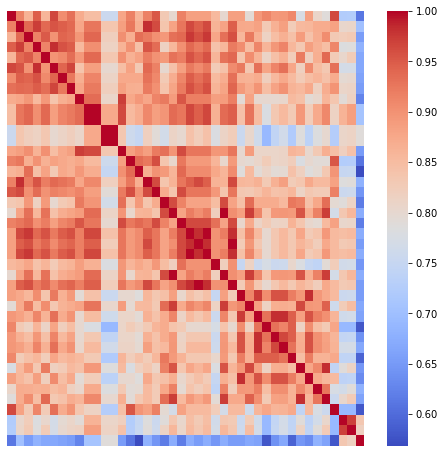

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(dice_sim, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.show()

#### Cosine similarity 

Cosine similarity is the dot product between two vectors and can be used on binary of continious data.  However, whenever we perform computations on real-valued data, such as the molecular descriptors we calculate we must ensure that each descriptor is on a simliar scale.  

For example, molecular weight can range typically from 1-500.  Where something like LogP is on the range from ~-5 - 5.  Typically, in order to compare these and give them equal weights, we do a process called standardizing.  This means substracting the mean from each descriptor and scaling to unit variance.  You can read more about standardizing [here](https://en.wikipedia.org/wiki/Standardization).  This is very important when doing any type of QSAR building or machine learning and using real-valued descriptors such as RDKit's molecular descriptors.  

There exists functionality in scikit learn to do this.  

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

desc_frame_std = pd.DataFrame(scaler.fit_transform(desc_frame))

desc_frame_std.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,-0.229804,-0.700378,-0.229804,-0.490113,0.400245,-0.844430,-0.945733,-0.839924,-0.427852,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.27735,0.0,0.0
1,-0.289638,-0.294427,-0.289638,0.485646,0.362171,-1.039932,-0.961257,-1.048096,-1.365407,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.27735,0.0,0.0
2,-0.196264,-0.003103,-0.196264,0.402070,0.944074,-0.321673,-0.318295,-0.326432,-0.427852,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.27735,0.0,0.0
3,-0.191039,-0.115072,-0.191039,0.457694,0.759743,-0.321673,-0.318295,-0.326432,-0.427852,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.27735,0.0,0.0
4,-0.149571,0.202131,-0.149571,0.290525,0.861595,-0.014158,0.003185,-0.017492,-0.115334,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.27735,0.0,0.0


In [11]:
cosine_sim = pd.DataFrame(1 - pairwise_distances(desc_frame_std.values, metric="cosine"))

cosine_sim.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,1.000000,0.208365,0.116956,0.292478,-0.213227,0.430990,0.078663,0.087533,0.498876,-0.228547,...,-0.268958,0.091292,-0.414969,0.117050,-0.381900,-0.456092,0.407760,-0.362560,-0.346742,-0.129260
1,0.208365,1.000000,0.721330,0.671706,0.144114,0.278297,-0.114483,-0.011173,0.288358,-0.420654,...,-0.460920,-0.687229,-0.333541,-0.286252,-0.638063,-0.465718,0.237089,-0.337720,-0.215816,-0.047979
2,0.116956,0.721330,1.000000,0.812463,0.289914,0.406813,0.371032,0.315903,0.339384,-0.166417,...,-0.376312,-0.569182,-0.328381,-0.410978,-0.516101,-0.356989,0.162737,-0.219743,-0.107685,-0.148829
3,0.292478,0.671706,0.812463,1.000000,0.168845,0.733062,0.440851,0.385513,0.256796,-0.128359,...,-0.227200,-0.537060,-0.454961,-0.217769,-0.513084,-0.502584,0.243585,-0.215008,-0.112401,-0.133828
4,-0.213227,0.144114,0.289914,0.168845,1.000000,0.011128,0.099276,0.223690,-0.079501,-0.094876,...,-0.118385,-0.270254,0.541584,-0.209048,0.218288,0.581466,-0.115312,-0.068701,-0.048020,-0.103765


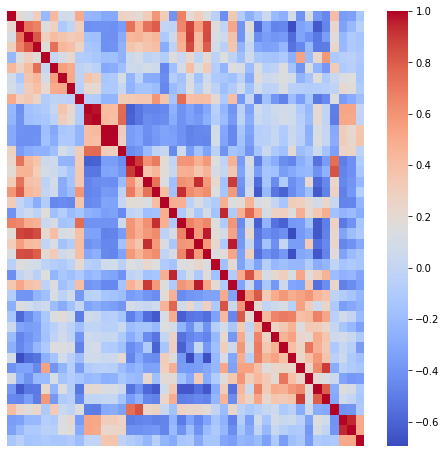

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(cosine_sim, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.show()

#### Euclidean distance

Euclidean distance is the most often used in real world scenarios. 

$$E(A,B) = \sqrt{\sum\limits_{i=1}^n (A_{i} - B_{i})^2}$$


In [13]:
euc_dist = pd.DataFrame(pairwise_distances(desc_frame_std.values, metric="euclidean"))

euc_dist.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.000000,10.488858,8.810892,7.994629,11.728801,7.397370,9.234843,9.627782,7.948978,13.617951,...,14.831739,12.938147,15.312712,11.969611,18.394735,15.509350,9.863338,19.938115,18.697801,29.816123
1,10.488858,0.000000,6.286014,6.642218,10.743769,9.245190,11.187981,11.128053,10.231554,15.658677,...,16.895887,18.464223,15.853902,15.308622,20.912921,16.597504,11.774819,20.643111,18.691291,29.644036
2,8.810892,6.286014,0.000000,3.299028,7.761732,6.153678,6.249510,7.010455,8.116183,11.768619,...,13.730291,14.845505,13.202994,13.251412,17.412181,13.305690,10.605692,17.786293,16.077208,29.116168
3,7.994629,6.642218,3.299028,0.000000,8.404008,4.176644,5.942647,6.698531,8.587766,11.658545,...,13.149797,14.793992,13.801385,12.499648,17.472014,13.978196,10.216713,17.813608,16.143983,29.071167
4,11.728801,10.743769,7.761732,8.404008,0.000000,9.424758,8.926387,8.704088,11.461112,12.693114,...,13.793780,14.948349,8.955817,13.736744,14.376771,8.591286,13.166566,17.931012,16.681583,29.537592


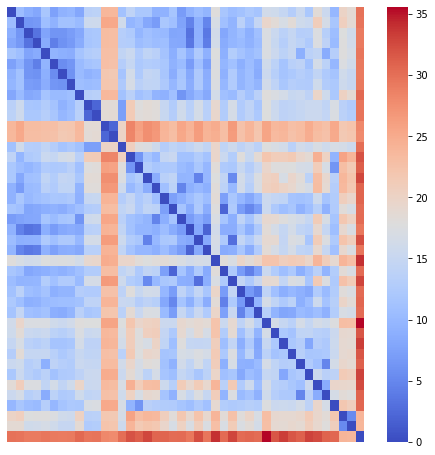

In [14]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.heatmap(euc_dist, cmap='coolwarm', xticklabels=False, yticklabels=False)
plt.show()